In [1]:
# load libs
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import numpy as np
import random
import matplotlib.pyplot as plt
import pickle

In [2]:
# definition of a simple fc model [2, 32, 64, 1]
class MOGANet(nn.Module):
    def __init__(self):
        super(MOGANet, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(11, 32),
            nn.ReLU(inplace=True),
            nn.Linear(32, 64),
            nn.ReLU(inplace=True),
            nn.Linear(64, 128),
            nn.ReLU(inplace=True),
            nn.Linear(128, 256),
            nn.ReLU(inplace=True),
            nn.Linear(256, 128),
            nn.ReLU(inplace=True),
            nn.Linear(128, 64),
            nn.ReLU(inplace=True),
            nn.Linear(64, 32),
            nn.ReLU(inplace=True),
            nn.Linear(32, 1),
        )
        
    def forward(self, x):
        x = self.fc(x)
        return x

class MOGADataset(Dataset):
    def __init__(self, x_tensor, y_tensor):
        self.x = x_tensor
        self.y = y_tensor
    
    def __len__(self):
        return len(self.x)
        
    def __getitem__(self, index):
        return (self.x[index], self.y[index])

In [3]:
# Use CUDA
device = torch.device("cpu")

random.seed(2020) 
torch.manual_seed(2020)
torch.cuda.manual_seed_all(2020)

# load files
moga = pickle.load(open("ma.1208.pkl", "rb"))
x_train, x_test = moga["x_train"], moga["x_test"]
y_train, y_test = moga["y_train"], moga["y_test"]
x_mean, x_std = moga["x_mean"], moga["x_std"]

x_train = torch.from_numpy(x_train).float()
y_train = torch.from_numpy(y_train.reshape(-1,1)).float()
x_test = torch.from_numpy(x_test).float()
y_test = torch.from_numpy(y_test.reshape(-1,1)).float()


In [4]:
model = MOGANet().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.8)

In [5]:
model.load_state_dict(torch.load("ma.1208.pth"))

<All keys matched successfully>

In [6]:
model.eval()
Yp = model(x_test)
print("test MSE from criterion")
MSE = criterion(Yp, y_test).item()
print(MSE)

Yp = Yp[:,0].detach().numpy()
y_test = y_test[:,0].detach().numpy()

delta_y = Yp - y_test
RMSE = np.sqrt(MSE)
print("test RMSE of original data")
print(RMSE)

test MSE from criterion
7.434193349808993e-08
test RMSE of original data
0.0002726571721009553


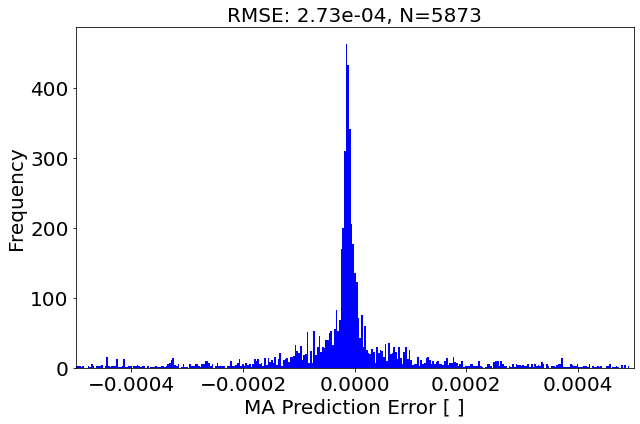

In [14]:
MEDIUM_SIZE = 20
#plt.rc('font', size=MEDIUM_SIZE) 
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize

plt.figure(figsize=(9,6))
num_bins = 2000
plt.hist(delta_y, num_bins, facecolor='blue')
plt.xlabel('MA Prediction Error [ ]')
plt.ylabel('Frequency')
plt.xlim(-0.0005,0.0005)

#plt.title('RMSE: %.4f, N=%d' % (RMSE,len(x_test)))
plt.title('RMSE: '+'{:.2e}'.format(RMSE)+', N=%d' % (len(x_test)))
plt.tight_layout()
plt.savefig('ma_retraining_example_histo.pdf')

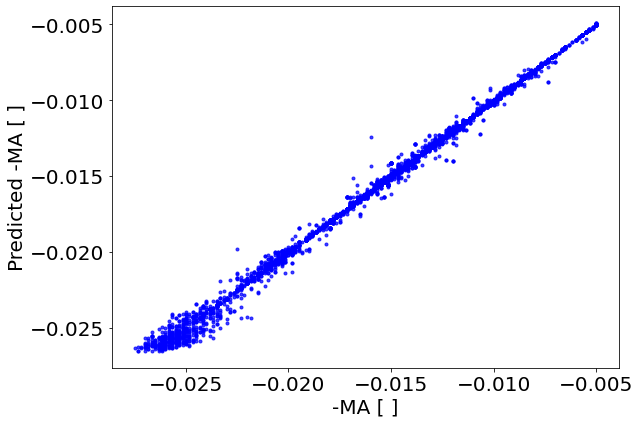

In [8]:
MEDIUM_SIZE = 20
#plt.rc('font', size=MEDIUM_SIZE) 
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize

plt.figure(figsize=(9,6))
#plt.ylim(-0.0252, -0.011) 
#plt.xlim(-0.027, -0.010) 
plt.scatter(y_test, Yp, color='b', marker=".", alpha=0.75)  
#plt.title('MA ')
plt.xlabel('-MA [ ]')
plt.ylabel('Predicted -MA [ ]')
plt.tick_params(axis='both', direction='out', grid_color='gray', grid_alpha=0.5)

plt.tight_layout()
plt.savefig('ma_retraining_example_comp.pdf')

No handles with labels found to put in legend.


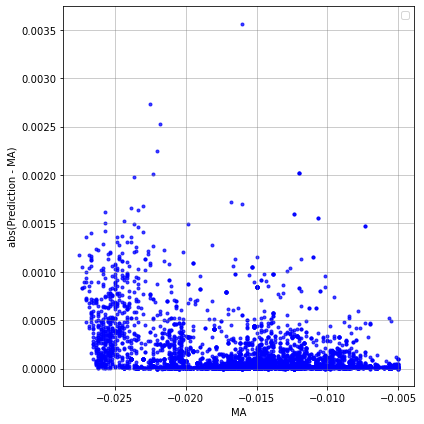

In [9]:
plt.figure(figsize=(6,6))
#plt.ylim(-0.0002, 0.003) 
#plt.xlim(-0.027, -0.010) 
plt.scatter(y_test, abs(Yp-y_test), color='b', marker=".", alpha=0.75)  
#plt.title('MA ')
plt.xlabel('MA')
plt.ylabel('abs(Prediction - MA)')
plt.tick_params(axis='both', direction='out', grid_color='gray', grid_alpha=0.5)
plt.legend()
plt.grid()
plt.tight_layout()
plt.savefig('6.jpg')